# Load the JSON files

In [19]:
import os
import warnings
warnings.simplefilter('ignore')
import gdown

DATA_PATH = '/content/drive/MyDrive/DATASETS/NELA/'
NELA_2018_SITE_SPLIT = 'nela_gt_2018_site_split/'

if os.path.isdir(NELA_2018_SITE_SPLIT):
  !rm -r {NELA_2018_SITE_SPLIT}
!cp -r {DATA_PATH + NELA_2018_SITE_SPLIT} {NELA_2018_SITE_SPLIT}


In [20]:
import pandas as pd
import json
import numpy as np

def jsonl_to_df(file_path):
    with open(file_path) as f:
        lines = f.read().splitlines()

    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']

    df_inter['json_element'].apply(json.loads)

    return pd.json_normalize(df_inter['json_element'].apply(json.loads))

In [21]:
train_df = jsonl_to_df(NELA_2018_SITE_SPLIT + 'train.jsonl')
train_df['split'] = 'train'
dev_df = jsonl_to_df(NELA_2018_SITE_SPLIT + 'dev.jsonl')
dev_df['split'] = 'dev'
test_df = jsonl_to_df(NELA_2018_SITE_SPLIT + 'test.jsonl')
test_df['split'] = 'test'

df = pd.concat([train_df, dev_df, test_df])

In [22]:
table = pd.pivot_table(df, values='title', index=['split'], columns=['label'], aggfunc='count', margins='all')
table

label,0,1,All
split,,,
dev,20294,20294,40588
test,19410,19410,38820
train,35302,35302,70604
All,75006,75006,150012


In [23]:
df.fillna('', inplace=True)
df.sample(5)

,content,title,date,source,label,split
30634,Russia and China are blocking a U.S. effort at...,Russia China Block US Bid At UN To Halt Fuel D...,2018-07-20,rferl,1,train
4254,A growing crowd of Central American migrants i...,Migrant Caravan Grows to 5000,2018-10-21,npr,1,train
8035,John Minton spent much of his life in torment ...,John Minton the Lost Man of British Art - a te...,2018-08-13,thetelegraph,1,dev
16171,(Natural News) You might think of air pollutio...,Common household chemicals 13 toxins you shoul...,2018-04-24,naturalnews,0,test
5898,What are you doing for Christmas? If the very ...,Why you should go skiing for Christmas instead...,2018-10-17,thetelegraph,1,dev


# BERT (Title Only)

In [24]:
!pip install transformers --q
!pip install datasets --q
!pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio===0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html --q
!pip install pytorch-lightning --q
!pip install torchmetrics --q

     |████████████████████████████████| 3.3 MB 7.4 MB/s 
     |████████████████████████████████| 61 kB 650 kB/s 
     |████████████████████████████████| 596 kB 56.0 MB/s 
     |████████████████████████████████| 895 kB 62.3 MB/s 
     |████████████████████████████████| 3.3 MB 45.8 MB/s 
     |████████████████████████████████| 298 kB 8.6 MB/s 
     |████████████████████████████████| 132 kB 55.1 MB/s 
     |████████████████████████████████| 1.1 MB 48.4 MB/s 
     |████████████████████████████████| 243 kB 41.0 MB/s 
     |████████████████████████████████| 271 kB 59.8 MB/s 
     |████████████████████████████████| 192 kB 56.0 MB/s 
     |████████████████████████████████| 160 kB 55.8 MB/s 
     |██████████████▋                 | 834.1 MB 1.1 MB/s eta 0:14:36tcmalloc: large alloc 1147494400 bytes == 0x55e885bbc000 @  0x7f66f928c615 0x55e84b8344cc 0x55e84b91447a 0x55e84b8372ed 0x55e84b928e1d 0x55e84b8aae99 0x55e84b8a59ee 0x55e84b838bda 0x55e84b8aad00 0x55e84b8a59ee 0x55e84b838bda 0x55e84b8a7737

In [25]:
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics import Accuracy, F1
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.metrics import classification_report, confusion_matrix

from collections import defaultdict

pl.seed_everything(42)

Global seed set to 42


42

In [26]:
MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [27]:
bert_model = BertModel.from_pretrained(MODEL_NAME, return_dict = True)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Class Declaration

In [28]:
class ReliableNews(Dataset):
  def __init__(self, data, tokenizer, max_token_len = 128):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    data_row = self.data.iloc[index]
    title = data_row.title
    labels = data_row.label

    encoding = self.tokenizer.encode_plus(
        title,
        add_special_tokens=True,
        max_length = self.max_token_len,
        return_token_type_ids = False,
        padding = 'max_length',
        truncation = True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )

    return dict(
        title = title,
        input_ids = encoding['input_ids'].flatten(),
        attention_mask = encoding['attention_mask'].flatten(),
        labels = torch.tensor(labels, dtype=torch.float32)
    )

def create_data_loader(df, tokenizer, max_len, batch_size, shuffle=False):
  ds = ReliableNews(
    df,
    tokenizer,
    max_token_len = max_len
  )

  return DataLoader(ds, batch_size = batch_size, shuffle = shuffle)

In [29]:
class ReliableNewsClassifier(nn.Module):
  def __init__(self, n_classes):
    super(ReliableNewsClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(MODEL_NAME)
    self.drop = nn.Dropout(p=0.1)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    x = self.bert(input_ids = input_ids, attention_mask = attention_mask)
    output = self.drop(x.pooler_output)
    return self.out(output)

## Training

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [51]:
MAX_LEN = 128
BATCH_SIZE = 8

train_df = df[df['split']=='train'].sample(50)
dev_df = df[df['split']=='dev'].sample(20)
test_df = df[df['split']=='test'].sample(10)

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=True)
val_data_loader = create_data_loader(dev_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [32]:
model = ReliableNewsClassifier(n_classes = 1)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
EPOCHS =10

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = total_steps//10,
    num_training_steps = total_steps
)

criterion = nn.BCEWithLogitsLoss().to(device)

## Train functions

In [62]:
def train_epoch(model, data_loader, criterion, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0

  for batch in tqdm(data_loader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    outputs = model(input_ids = input_ids, attention_mask = attention_mask)

    preds = torch.round(outputs)
    loss = criterion(outputs, labels.unsqueeze(1))

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)

def eval_model(model, data_loader, criterion, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for batch in tqdm(data_loader):
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.round(outputs)

      loss = criterion(outputs, labels.unsqueeze(1))

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [60]:
acc, loss = eval_model(model, val_data_loader, criterion, device, len(dev_df))

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([[0.4249],
        [0.3042],
        [0.4276],
        [0.4148],
        [0.2623],
        [0.4561],
        [0.3883],
        [0.3866]])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([1., 0., 0., 1., 1., 1., 1., 0.])
tensor([[0.5330],
        [0.3979],
        [0.3906],
        [0.4279],
        [0.3598],
        [0.4444],
        [0.4235],
        [0.4350]])
tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.4639],
        [0.4807],
        [0.4667],
        [0.5261]])
tensor([[0.],
        [0.],
        [0.],
        [1.]])
tensor([1., 1., 1., 1.])


In [61]:
acc

tensor(3.6000, dtype=torch.float64)

In [43]:
x = torch.tensor([1])
x1 = torch.tensor([1.0])
torch.max(x)==x1

tensor([True])

## Training Loop

In [63]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch:{epoch+1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      criterion,
      optimizer,
      device,
      scheduler,
      len(train_df)
  )

  print(f'Train loss = {train_loss}, Train acc = {train_acc}')

  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      criterion,
      device,
      len(dev_df)
  )

  print(f'Val loss = {val_loss}, Val acc = {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch:1/10
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss = 0.682412930897304, Train acc = 3.6


  0%|          | 0/3 [00:00<?, ?it/s]

Val loss = 0.6587354938189188, Val acc = 3.8
Epoch:2/10
----------


  0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

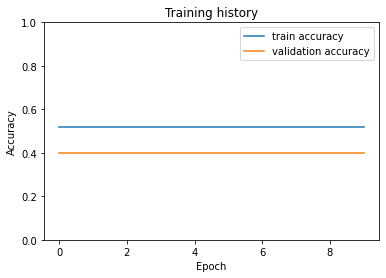

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  criterion,
  device,
  len(test_df)
)

test_acc.item()

  0%|          | 0/3 [00:00<?, ?it/s]

0.25

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in tqdm(data_loader):

      texts = d["title"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      # probs = nn.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      # prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  # prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, real_values

In [ ]:
y_review_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40         5
         1.0       0.00      0.00      0.00        15

    accuracy                           0.25        20
   macro avg       0.12      0.50      0.20        20
weighted avg       0.06      0.25      0.10        20

